## Boston Housing Data: Regression example
- Attempt to predict the median price of homes in given suburb in mid 1970s. Range between $10000  to  $50000
- total data point 506, split into training of 404 and testing 102.
- Each feature of the input has different scale. Total 13 numerical features.

In [1]:
from keras.datasets import boston_housing

2024-06-01 21:53:40.210320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(train_data, train_targets),(test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 5us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Preparing the dataset

- Since the features are wildly different in range, feature-wise normalisation is applied
- All the features will be centered at 0 and has unit standard deviation.

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

# In the workflow any quantity computed on the test data, even something as simple as normalization should never be used.
# mean and std calculated on train data is used on test data.

### Building the network
- small sample size, hence small network with two hidden layers, each with 64 units.
- Less training data, worse overfitting, mitigate overfit by small network.
- Network end with a single unit and no activation as it would constrain the range of the value output can take.
- typical setup for scalar regression (trying to predict single continuous value)
- loss is monitored using MSE for regression problems.
- And metrics used is MAE. If MAE is 0.5 it indicates the predictions to be off by 500 dollars on average.

In [7]:
from keras import models
from keras import layers

In [8]:
def build_model():      # Because we need to instantiate the model multiple times a function is used to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
    return model

### Validating using K-fold validation

- Due to small size of dataset the validation set split will turn out to be small.
- The validation score might end up with a high variance with regrad to validation split.
- This can be avoided by using K-fold cross validation.

#### K-fold quick glance
- Split the available data into k-partitions.
- Instantiate k identical models.
- Train each model on k-1 partition and evaluate on remaining partition.
- calculate average of k validation scores obtained.

In [11]:
import numpy as np

k=4
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []

for i in range(k):
    # prepare the validation data: data from partition #k
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    #prepare training data: data from other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
         axis=0)
    #Builds the already compiled keras model
    model = build_model()
    model.fit(partial_train_data,partial_train_targets,epochs=num_epochs,batch_size=1,verbose=0) # trains the model
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) #validates the model
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [12]:
all_scores

[2.3684332370758057, 2.489269256591797, 2.6077091693878174, 2.640620470046997]

In [13]:
np.mean(all_scores)

2.5265080332756042

The interpretation that the model's predictions are off by approximately $2500 on average comes from the Mean Absolute Error (MAE) values. Let's go through the reasoning and how this conclusion is reached step by step.

##### Understanding the Boston Housing Dataset
The Boston Housing dataset contains information about housing prices in Boston suburbs, along with various features that might influence these prices (e.g., crime rate, number of rooms, etc.). The target variable is the median value of owner-occupied homes in $1000s.

##### Mean Absolute Error (MAE)
The MAE values you provided are around 2.368 to 2.641. In the context of the Boston Housing dataset, the target variable (median value of owner-occupied homes) is measured in $1000s.

##### Calculating the Average MAE
From the output of the k-fold validation:
\[ \text{Average MAE} = \frac{2.368 + 2.489 + 2.608 + 2.641}{4} = 2.526 \]

##### Interpreting the MAE in the Context of the Dataset
Since the target values in the Boston Housing dataset are in units of $1000s, an MAE of approximately 2.526 means that, on average, the predictions are off by 2.526 units of $1000s.

##### Converting to Dollars
To convert this to dollars:
\[ \text{Average Error in Dollars} = 2.526 \times 1000 = 2526 \]

##### Conclusion
Therefore, the statement that the output is off by approximately $2500 on average is derived from the fact that the average MAE is around 2.526 (in units of $1000s), which translates to approximately $2526. This means that on average, the predicted house prices are about $2526 away from the actual prices. This is a reasonable conclusion given the provided MAE values and the nature of the target variable in the dataset.

In [17]:
# Saving Validation logs at each fold

num_epochs = 500
all_mae_histories = []
for i in range(k):
    # prepare the validation data: partitions #k
     print('processing fold #', i)
     val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
     val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    #prepare training data: data from other partitions
     partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
         axis=0)
     partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
         axis=0)
    #Builds the already compiled keras model
     model = build_model()
     history = model.fit(partial_train_data,partial_train_targets,validation_data=(val_data,val_targets),epochs=num_epochs,batch_size=1,verbose=0) # trains the model
     mae_history = history.history['val_mae']
     all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [18]:
average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

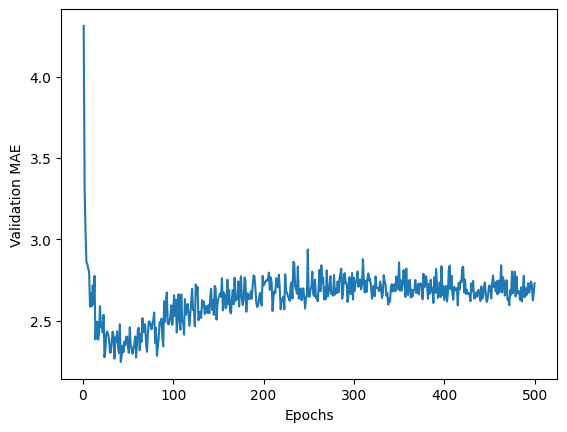

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

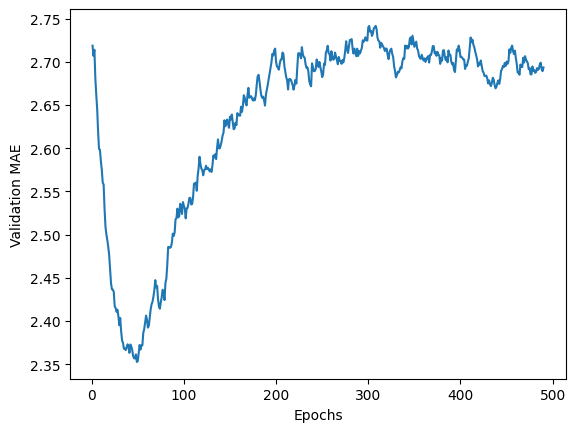

In [21]:
# smoothning the curve by dropping first 10 data points as the scale are different and replacing each point with moving average of previous points

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) +1),smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [24]:
# Training the final model

model =  build_model()
model.fit(train_data,train_targets, epochs= 80, batch_size =16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 19.2609 - mae: 2.7724


In [25]:
test_mae_score

2.772376775741577

- Still off by $2772.

#### Key take away
- The loss function for regression is different from classification.
- Mean Squared Error is the loss function commonly used for regression.
- The evaluation metric used for regression is Mean Absolute Error.
- Each feature should be scaled independently in preprocessing, to not let different ranges affect.
- K-fold validation is a great way to reliably evaluate a small dataset.
- When training data is small, using small neural networks